In [1]:
import pandas as pd
import numpy as np
import keras
import gensim
import pickle
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
%matplotlib inline

%load_ext autoreload
%autoreload 2
import helper

Using TensorFlow backend.


In [2]:
X_train = np.load("data/word_vectors/pubmed_binary_stratify_no_wiki_X_train_seeds42.npy")
y_train = np.load("data/word_vectors/pubmed_binary_stratify_no_wiki_y_train_seeds42.npy")

In [3]:
X_test = np.load("data/word_vectors/pubmed_binary_stratify_no_wiki_X_test_seeds42.npy")
y_test = np.load("data/word_vectors/pubmed_binary_stratify_no_wiki_y_test_seeds42.npy")

In [4]:
X_train = np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

In [5]:
X_train.shape

(2155, 100, 200)

In [6]:
input_shape = (100, 200)

# Model

In [7]:
input_shape = (100, 200)
filters = 128
kernel_size = 3
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters,
             kernel_size,
             padding='valid',
             activation='relu',
             strides=1, input_shape=input_shape))
model.add(keras.layers.MaxPool1D(pool_size=48))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.recurrent.GRU(64))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 98, 128)           76928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 114,049
Trainable params: 114,049
Non-trainable params: 0
_________________________________________________________________
None

8

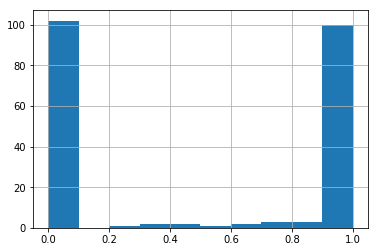

In [8]:
model.compile(optimizer="adagrad",
              loss='binary_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_split=0.1, epochs=15, batch_size=256)
yhat = model.predict(X_test)
_ = helper.score_prediction(y_test, yhat, binary=True)
gc.collect()

In [9]:
del X_train
del X_test

In [10]:
gc.collect()

0

# Submission

In [13]:
submission_vectors = np.load("data/submission_binary_word_vectors.npy")
submission_ids = np.load("data/submission_binary_ids.npy")

### Reconstruct the categories from the one-hot encoding

In [14]:
yhat = model.predict(submission_vectors)

In [15]:
submission_df = helper.create_binary_submission(yhat, submission_ids)

In [16]:
submission_df.head()

,Id,Category
0,751,cancer
1,299,cancer
2,3,cancer
3,2091,nonCancer
4,1908,nonCancer


In [17]:
len(submission_df)

381

In [18]:
submission_df.to_csv("data/binary_submissions_recurrent_cnn.csv", index=False)